In [ ]:
# checkpoint_sarima_bulk.py
import warnings, os, time, math
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pathlib import Path

# --- SETTINGS (tune as needed) ---
CSV_PATH = "/content/stocks_df.csv"
OUT_SUM = "./sarima_results_summary_checkpoint.csv"
OUT_PREDS = "./sarima_predictions_15days_checkpoint.csv"

CHECKPOINT_EVERY = 50           # save to disk every N stocks
MIN_TRAIN_DAYS = 60            # require at least MIN_TRAIN_DAYS + 15
FORECAST_HORIZON = 15
SAR_ORDER = (1,1,1)
SAR_SEASONAL = (0,1,1,5)       # seasonal period 5 (weekly trading)
# ---------------------------------

print("Loading data...")
df = pd.read_csv(CSV_PATH, parse_dates=["Date"])
df = df.sort_values(["Stock","Date"]).reset_index(drop=True)

stocks = df['Stock'].unique()
print(f"Found {len(stocks)} stocks total.")

# load existing checkpoint if present
if Path(OUT_SUM).exists() and Path(OUT_PREDS).exists():
    print("Found existing checkpoint files. Resuming from checkpoint...")
    results_df = pd.read_csv(OUT_SUM)
    preds_df = pd.read_csv(OUT_PREDS)
    processed_stocks = set(results_df['Stock'].tolist())
else:
    results_df = pd.DataFrame(columns=["Stock","n_obs","status","rmse","mape"])
    preds_df = pd.DataFrame(columns=["Stock","Date","actual","pred"])
    processed_stocks = set()

start_time = time.time()
processed = 0

for stock in stocks:
    if stock in processed_stocks:
        continue

    stock_df = df[df['Stock']==stock][['Date','Close']].dropna()
    stock_df = stock_df.drop_duplicates(subset='Date').sort_values('Date')
    n = len(stock_df)
    if n < MIN_TRAIN_DAYS + FORECAST_HORIZON:
        results_df = pd.concat([results_df, pd.DataFrame([{
            "Stock": stock, "n_obs": n, "status": "too_short", "rmse": np.nan, "mape": np.nan
        }])], ignore_index=True)
        processed_stocks.add(stock)
    else:
        train = stock_df.iloc[:-FORECAST_HORIZON].set_index('Date')['Close']
        test = stock_df.iloc[-FORECAST_HORIZON:].set_index('Date')['Close']
        try:
            model = SARIMAX(train, order=SAR_ORDER, seasonal_order=SAR_SEASONAL,
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=100)
            pred = res.get_forecast(steps=FORECAST_HORIZON)
            y_pred = pred.predicted_mean
            # align index
            if len(y_pred) == len(test):
                y_pred.index = test.index
            rmse = np.sqrt(mean_squared_error(test, y_pred))

            mape = np.mean(np.abs((test - y_pred) / np.where(test==0, np.nan, test))) * 100
            status = "ok"
        except Exception as e:
            last = train.iloc[-1]
            y_pred = pd.Series([last]*FORECAST_HORIZON, index=test.index)
            rmse = np.sqrt(mean_squared_error(test, y_pred))

            mape = np.mean(np.abs((test - y_pred) / np.where(test==0, np.nan, test))) * 100
            status = "fallback_naive"

        results_df = pd.concat([results_df, pd.DataFrame([{
            "Stock": stock, "n_obs": n, "status": status, "rmse": float(rmse), "mape": float(mape)
        }])], ignore_index=True)

        for d, actual, predv in zip(test.index, test.values, y_pred.values):
            preds_df = pd.concat([preds_df, pd.DataFrame([{
                "Stock": stock, "Date": pd.to_datetime(d), "actual": float(actual), "pred": float(predv)
            }])], ignore_index=True)

        processed_stocks.add(stock)

    processed += 1
    # checkpoint regularly
    if processed % CHECKPOINT_EVERY == 0:
        print(f"Checkpoint: processed {processed} new stocks, saving files...")
        results_df.to_csv(OUT_SUM, index=False)
        preds_df.to_csv(OUT_PREDS, index=False)
        elapsed = time.time() - start_time
        print(f"Elapsed {elapsed:.0f}s")

# final save
results_df.to_csv(OUT_SUM, index=False)
preds_df.to_csv(OUT_PREDS, index=False)
print("Done. Total new stocks processed:", processed)
print("Summary saved to:", OUT_SUM)
print("Predictions saved to:", OUT_PREDS)


Loading data...
Found 1749 stocks total.
Checkpoint: processed 50 new stocks, saving files...
Elapsed 189s
Checkpoint: processed 100 new stocks, saving files...
Elapsed 378s
Checkpoint: processed 150 new stocks, saving files...
Elapsed 560s
Checkpoint: processed 200 new stocks, saving files...
Elapsed 793s
Checkpoint: processed 250 new stocks, saving files...
Elapsed 1006s
Checkpoint: processed 300 new stocks, saving files...
Elapsed 1221s
Checkpoint: processed 350 new stocks, saving files...
Elapsed 1394s
Checkpoint: processed 400 new stocks, saving files...
Elapsed 1552s
Checkpoint: processed 450 new stocks, saving files...
Elapsed 1771s
Checkpoint: processed 500 new stocks, saving files...
Elapsed 1961s
Checkpoint: processed 550 new stocks, saving files...
Elapsed 2154s
Checkpoint: processed 600 new stocks, saving files...
Elapsed 2335s
Checkpoint: processed 650 new stocks, saving files...
Elapsed 2586s
Checkpoint: processed 700 new stocks, saving files...
Elapsed 2779s
Checkpoint: 

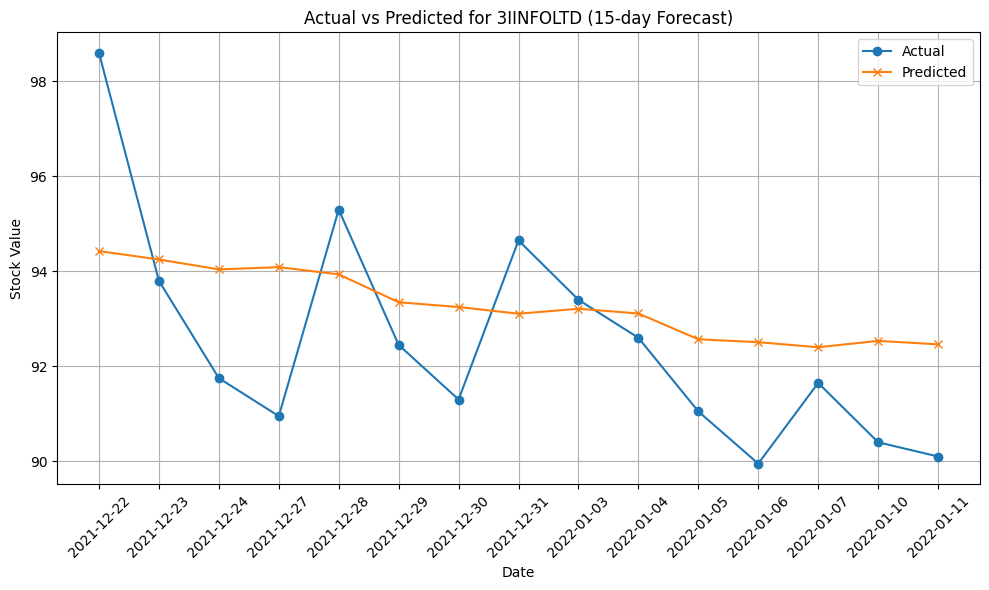

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions file
preds_df = pd.read_csv("/content/sarima_predictions_15days_checkpoint.csv")

# Choose a stock to visualize
stock_name = "3IINFOLTD"   # <-- replace with any company name from your dataset

# Filter for that stock
stock_data = preds_df[preds_df['Stock'] == stock_name]

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(stock_data['Date'], stock_data['actual'], marker='o', label="Actual")
plt.plot(stock_data['Date'], stock_data['pred'], marker='x', label="Predicted")

plt.title(f"Actual vs Predicted for {stock_name} (15-day Forecast)")
plt.xlabel("Date")
plt.ylabel("Stock Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
